In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as ss
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('raw/training_v2.csv') 
# the training data. You should see 91,713 encounters represented here

In [4]:
df.shape

(91713, 186)

# Deal with missing values

In [5]:
df = df.replace('nan', np.nan)

# What are the independent variabels?

In [6]:
independent = df.iloc[:, 4:185]
independent['encounter_id'] = df['encounter_id']
independent['patient_id'] = df['patient_id']
independent['hospital_id'] = df['hospital_id']

# Now the dependent variable

In [9]:
dependent = df.iloc[:, 3]
dependent = dependent.to_frame()

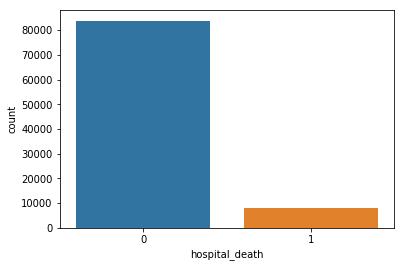

In [82]:
sns.countplot(dependent['hospital_death'])

# Take a look at independent variables

In [10]:
independent.head(3)

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,encounter_id,patient_id,hospital_id
0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,66154,25312,118
1,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.

In [11]:
check_nan = df.isin([np.nan])

In [12]:
col_nan_percent = check_nan.mean()

In [13]:
print (col_nan_percent)

encounter_id                     0.000000
patient_id                       0.000000
hospital_id                      0.000000
hospital_death                   0.000000
age                              0.046100
bmi                              0.037388
elective_surgery                 0.000000
ethnicity                        0.015210
gender                           0.000273
height                           0.014545
hospital_admit_source            0.233435
icu_admit_source                 0.001221
icu_id                           0.000000
icu_stay_type                    0.000000
icu_type                         0.000000
pre_icu_los_days                 0.000000
readmission_status               0.000000
weight                           0.029658
albumin_apache                   0.592926
apache_2_diagnosis               0.018122
apache_3j_diagnosis              0.012005
apache_post_operative            0.000000
arf_apache                       0.007796
bilirubin_apache                 0

In [14]:
df = df.loc[:, col_nan_percent < .7]

# string categorical variables

In [15]:
# categorical but also text based
categorical_cols =  ['ethnicity', 'gender', 
                     'hospital_admit_source', 'icu_admit_source', 
                     'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 
                     'apache_2_bodysystem',"hospital_death",'age']

# encode categorical variable

## Gender
### 0 - female; 1 - male

In [16]:
Categorical_df= df[categorical_cols]
le = LabelEncoder()  
gender = pd.DataFrame(le.fit_transform(Categorical_df['gender'].astype('str')))
gender.columns = ['Gender']

In [17]:
df['gender'] = gender['Gender']

#  Encode ethnicity

### 0 - African American; 1 - Asian; 2 - Caucasian; 3 - Hispanic; 4 - Native American; 5 - Other/Unknown; 6 - nan

In [18]:
le = LabelEncoder()  
ethnicity = pd.DataFrame(le.fit_transform(Categorical_df['ethnicity'].astype('str')))
ethnicity.columns = ['ethnicity']


In [19]:
df['ethnicity'] = ethnicity['ethnicity']

### Hospital admit source (e.g. floor, emergency department)

In [20]:
le = LabelEncoder()  
hospital_admit_source = pd.DataFrame(le.fit_transform(Categorical_df['hospital_admit_source'].astype('str')))
hospital_admit_source.columns = ['hospital_admit_source']
df['hospital_admit_source'] = hospital_admit_source['hospital_admit_source']

### ICU admit source

In [21]:
le = LabelEncoder()  
icu_admit_source = pd.DataFrame(le.fit_transform(Categorical_df['icu_admit_source'].astype('str')))
icu_admit_source.columns = ['icu_admit_source']
df['icu_admit_source'] = icu_admit_source['icu_admit_source']

### icu_stay_type (e.g. admit, readmit)

In [22]:
le = LabelEncoder()  
icu_stay_type = pd.DataFrame(le.fit_transform(Categorical_df['icu_stay_type'].astype('str')))
icu_stay_type.columns = ['icu_stay_type']
df['icu_stay_type'] = icu_stay_type['icu_stay_type']

### icu_type (e.g. Neuro ICU, Med-Surg ICU)

In [23]:
le = LabelEncoder()  
icu_type = pd.DataFrame(le.fit_transform(Categorical_df['icu_type'].astype('str')))
icu_type.columns = ['icu_type']
df['icu_type'] = icu_type['icu_type']

### apache_3j_bodysystem (e.g. Cardiovascular, Neurological)

In [24]:
le = LabelEncoder()  
apache_3j_bodysystem = pd.DataFrame(le.fit_transform(Categorical_df['apache_3j_bodysystem'].astype('str')))
apache_3j_bodysystem.columns = ['apache_3j_bodysystem']
df['apache_3j_bodysystem'] = apache_3j_bodysystem['apache_3j_bodysystem']

### apache_2_bodysystem (e.g. Cardiovascular, Neurological)

In [25]:
le = LabelEncoder()  
apache_2_bodysystem = pd.DataFrame(le.fit_transform(Categorical_df['apache_2_bodysystem'].astype('str')))
apache_2_bodysystem.columns = ['apache_2_bodysystem']
df['apache_2_bodysystem'] = apache_2_bodysystem['apache_2_bodysystem']

# Correlation table between all independent variables
## Drop those are collinear

In [26]:
y = df['hospital_death']
X = df.copy()
X = df.drop('hospital_death',axis = 1)

In [27]:
corr_matrix = X.corr().abs()
corr_matrix.head(10)

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
encounter_id,1.000000,0.009575,0.004532,0.003990,0.001068,0.002036,0.002507,0.003101,0.005400,0.001498,0.000905,0.000992,0.003214,0.001751,0.000570,NaN,0.004376,0.006262,0.000113,0.000651,0.001138,0.007920,0.002198,0.002619,0.005435,0.003276,0.007664,0.002400,0.006516,0.002108,0.001718,0.001566,0.003172,0.000759,0.006498,0.007004,0.005162,0.009225,0.005775,0.009363,0.002547,0.000802,0.002229,0.001202,0.003891,0.002045,0.000332,0.000553,0.000734,0.000472,0.006880,0.000296,0.000041,0.000512,0.000484,0.002455,0.000063,0.002115,0.004533,0.003035,0.001529,0.003506,0.000586,0.005045,0.000167,0.000930,0.000261,0.002202,0.000654,0.002838,0.002682,0.000351,0.001577,0.004182,0.002714,0.000849,0.002974,0.001240,0.003970,0.001013,0.003400,0.004386,0.001386,0.000563,0.002679,0.002602,0.002559,0.004862,0.005521,0.004719,0.003672,0.002068,0.001422,0.002499,0.001250,0.000771,0.001625,0.000353,0.006878,0.005783,0.001177,0.002054,0.001755,0.000521,0.006234,0.004110,0.006574,0.005540,0.002031,0.002028,0.006878,0.005783,0.010535,0.011311,0.006958,0.002549,0.003484,0.002009,0.000513,0.000344,0.001907,0.007601,0.003402,0.000972,0.001707,0.002172,0.001176,0.004646,0.000906,0.001832
patient_id,0.009575,1.000000,0.007075,0.006343,0.001380,0.001387,0.002644,0.001269,0.002902,0.006496,0.003032,0.001770,0.000196,0.003114,0.004412,NaN,0.000275,0.001534,0.001539,0.004215,0.002260,0.003980,0.004292,0.002860,0.004134,0.001551,0.002216,0.006673,0.000471,0.000270,0.004735,0.002944,0.001303,0.002413,0.000179,0.011433,0.002535,0.006058,0.004433,0.002185,0.003287,0.004180,0.002946,0.004605,0.001330,0.001570,0.004471,0.003249,0.004160,0.003740,0.003159,0.002041,0.002040,0.002318,0.000021,0.006877,0.000188,0.007695,0.000807,0.003264,0.006719,0.008462,0.007044,0.011464,0.000688,0.001328,0.005861,0.008053,0.006467,0.010379,0.004802,0.001478,0.001787,0.000198,0.003579,0.006587,0.004689,0.009214,0.005062,0.005804,0.000729,0.002537,0.004328,0.004302,0.002200,0.00239

In [28]:
# Correlation table are symmetrical; only keep upper half
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

In [29]:
upper = corr_matrix.where(mask)
#corr_matrix = corr_matrix[mask]

In [30]:
upper.head(10)

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
encounter_id,1.0,0.009575,0.004532,0.003990,0.001068,0.002036,0.002507,0.003101,0.005400,0.001498,0.000905,0.000992,0.003214,0.001751,0.000570,NaN,0.004376,0.006262,0.000113,0.000651,0.001138,0.007920,0.002198,0.002619,0.005435,0.003276,0.007664,0.002400,0.006516,0.002108,0.001718,0.001566,0.003172,0.000759,0.006498,0.007004,0.005162,0.009225,0.005775,0.009363,0.002547,0.000802,0.002229,0.001202,0.003891,0.002045,0.000332,0.000553,0.000734,0.000472,0.006880,0.000296,0.000041,0.000512,0.000484,0.002455,0.000063,0.002115,0.004533,0.003035,0.001529,0.003506,0.000586,0.005045,0.000167,0.000930,0.000261,0.002202,0.000654,0.002838,0.002682,0.000351,0.001577,0.004182,0.002714,0.000849,0.002974,0.001240,0.003970,0.001013,0.003400,0.004386,0.001386,0.000563,0.002679,0.002602,0.002559,0.004862,0.005521,0.004719,0.003672,0.002068,0.001422,0.002499,0.001250,0.000771,0.001625,0.000353,0.006878,0.005783,0.001177,0.002054,0.001755,0.000521,0.006234,0.004110,0.006574,0.005540,0.002031,0.002028,0.006878,0.005783,0.010535,0.011311,0.006958,0.002549,0.003484,0.002009,0.000513,0.000344,0.001907,0.007601,0.003402,0.000972,0.001707,0.002172,0.001176,0.004646,0.000906,0.001832
patient_id,NaN,1.000000,0.007075,0.006343,0.001380,0.001387,0.002644,0.001269,0.002902,0.006496,0.003032,0.001770,0.000196,0.003114,0.004412,NaN,0.000275,0.001534,0.001539,0.004215,0.002260,0.003980,0.004292,0.002860,0.004134,0.001551,0.002216,0.006673,0.000471,0.000270,0.004735,0.002944,0.001303,0.002413,0.000179,0.011433,0.002535,0.006058,0.004433,0.002185,0.003287,0.004180,0.002946,0.004605,0.001330,0.001570,0.004471,0.003249,0.004160,0.003740,0.003159,0.002041,0.002040,0.002318,0.000021,0.006877,0.000188,0.007695,0.000807,0.003264,0.006719,0.008462,0.007044,0.011464,0.000688,0.001328,0.005861,0.008053,0.006467,0.010379,0.004802,0.001478,0.001787,0.000198,0.003579,0.006587,0.004689,0.009214,0.005062,0.005804,0.000729,0.002537,0.004328,0.004302,0.002200,0.002391,0.003670

In [31]:
# mask all zeros
upper = upper.replace(1, np.nan)

In [32]:
upper.head(10)

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
encounter_id,NaN,0.009575,0.004532,0.003990,0.001068,0.002036,0.002507,0.003101,0.005400,0.001498,0.000905,0.000992,0.003214,0.001751,0.000570,NaN,0.004376,0.006262,0.000113,0.000651,0.001138,0.007920,0.002198,0.002619,0.005435,0.003276,0.007664,0.002400,0.006516,0.002108,0.001718,0.001566,0.003172,0.000759,0.006498,0.007004,0.005162,0.009225,0.005775,0.009363,0.002547,0.000802,0.002229,0.001202,0.003891,0.002045,0.000332,0.000553,0.000734,0.000472,0.006880,0.000296,0.000041,0.000512,0.000484,0.002455,0.000063,0.002115,0.004533,0.003035,0.001529,0.003506,0.000586,0.005045,0.000167,0.000930,0.000261,0.002202,0.000654,0.002838,0.002682,0.000351,0.001577,0.004182,0.002714,0.000849,0.002974,0.001240,0.003970,0.001013,0.003400,0.004386,0.001386,0.000563,0.002679,0.002602,0.002559,0.004862,0.005521,0.004719,0.003672,0.002068,0.001422,0.002499,0.001250,0.000771,0.001625,0.000353,0.006878,0.005783,0.001177,0.002054,0.001755,0.000521,0.006234,0.004110,0.006574,0.005540,0.002031,0.002028,0.006878,0.005783,0.010535,0.011311,0.006958,0.002549,0.003484,0.002009,0.000513,0.000344,0.001907,0.007601,0.003402,0.000972,0.001707,0.002172,0.001176,0.004646,0.000906,0.001832
patient_id,NaN,NaN,0.007075,0.006343,0.001380,0.001387,0.002644,0.001269,0.002902,0.006496,0.003032,0.001770,0.000196,0.003114,0.004412,NaN,0.000275,0.001534,0.001539,0.004215,0.002260,0.003980,0.004292,0.002860,0.004134,0.001551,0.002216,0.006673,0.000471,0.000270,0.004735,0.002944,0.001303,0.002413,0.000179,0.011433,0.002535,0.006058,0.004433,0.002185,0.003287,0.004180,0.002946,0.004605,0.001330,0.001570,0.004471,0.003249,0.004160,0.003740,0.003159,0.002041,0.002040,0.002318,0.000021,0.006877,0.000188,0.007695,0.000807,0.003264,0.006719,0.008462,0.007044,0.011464,0.000688,0.001328,0.005861,0.008053,0.006467,0.010379,0.004802,0.001478,0.001787,0.000198,0.003579,0.006587,0.004689,0.009214,0.005062,0.005804,0.000729,0.002537,0.004328,0.004302,0.002200,0.002391,0.003670,0.00

In [33]:
threshold = 0.9
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
#Drop the columns with high correlations
X = X.drop(columns = to_drop)

There are 30 columns to remove.


In [34]:
df = df.drop(columns = to_drop)

In [35]:
df.shape

(91713, 101)

In [36]:
X.shape

(91713, 100)

In [73]:
clean_data = pd.concat([X,y], axis = 1)

In [75]:
clean_data.to_csv('clean_data.csv', sep=',', encoding='utf-8')